In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as stats
plt.rc('text', usetex=False)
sns.set('notebook', font_scale=1.5, font='serif')

# Random Numbers

## Scipy functions

In [10]:
# Create a random variable
rv = stats.beta(a=0.5, b=0.5)
n, xs = 5, [0.1, 0.5, 0.9]

print(rv.pdf(xs)) # PDF function at xs
print(rv.cdf(xs)) # CDF function at xs
print(rv.rvs(n))  # generate n i.i.d. sample of rv

# Compute moments
mean, var, skew, kurt = rv.stats(moments='mvsk')
print(mean, var, skew, kurt)

[1.06103295 0.63661977 1.06103295]
[0.20483276 0.5        0.79516724]
[0.28013633 0.99798552 0.17047189 0.15602316 0.98863431]
0.5 0.125 0.0 -1.5


## Inverse transform method

Once we have standard uniform numbers, we can often generate random numbers from other distribution using the inverse transform method. Recall that if $X$ is a continuous random variable with CDF $F_X$, then $Y = F_X(X)$ has the standard uniform distribution. Inverting this suggests that if $Y$ comes from a standard uniform distribution, then $F_X^{-1}(Y)$ has the same distribution as $X$. The inverse transform method is used below to generate random numbers from the exponential distribution.

In [19]:
def expon_pdf(x, lmabd=1):
    """PDF of exponential distribution."""
    return lmabd*np.exp(-lmabd*x)

def expon_cdf(x, lambd=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-lambd*x)

def expon_icdf(p, lambd=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/lambd

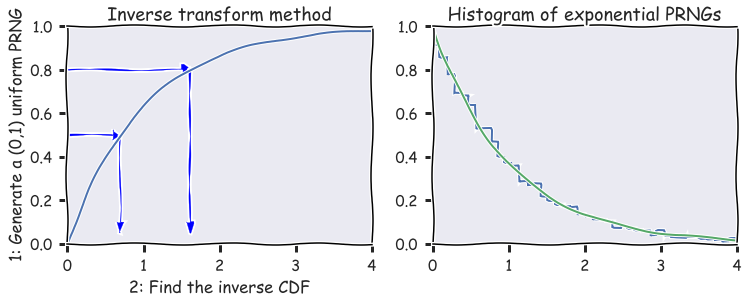

In [20]:
dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, expon_cdf(x))
    plt.axis([0, 4, 0, 1])
    for q in [0.5, 0.8]:
        plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method');

    plt.subplot(122)
    u = np.random.random(10000)
    v = expon_icdf(u)
    plt.hist(v, histtype='step', bins=100, normed=True, linewidth=2)
    plt.plot(x, expon_pdf(x), linewidth=2)
    plt.axis([0,4,0,1])
    plt.title('Histogram of exponential PRNGs');

### Inverse transform from sample data

Suppose we have some random samples with an unknown distribution. We can still use the inverse transform method to create a random number generator from a random sample, by estimating the inverse CDF function using interpolation.

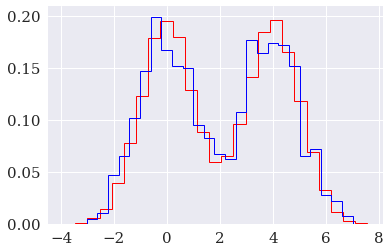

In [3]:
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF

# Make up some random data
x = np.concatenate([np.random.normal(0, 1, 10000), 
                    np.random.normal(4, 1, 10000)])

ecdf = ECDF(x)
inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, assume_sorted=True)
r = np.random.uniform(0, 1, 1000)
ys = inv_cdf(r)

plt.hist(x, 25, histtype='step', color='red', normed=True, linewidth=1)
plt.hist(ys, 25, histtype='step', color='blue', normed=True, linewidth=1);

## Box-Muller for generating normally distributed random numbers

The Box-Muller transform starts with 2 random uniform numbers $u$ and $v$
- Generate an exponentially distributed variable $r^2$ from $u$ using the inverse transform method
- This means that $r$ is an exponentially distributed variable on $(0, \infty)$
- Generate a variable $\theta$ uniformly distributed on $(0, 2\pi)$ from $v$ by scaling
- In polar coordinates, the vector $(r, \theta)$ has an independent bivariate normal distribution
- Hence the projection onto the $x$ and $y$ axes give independent univariate normal random numbers

Note:

- Normal random numbers can also be generated using the *general* inverse transform method (e.g. by approximating the inverse CDF with a polynomial) or the rejection method (e.g. using the exponential distribution as the sampling distribution). 
- There is also a variant of Box-Muller that does not require the use of (expensive) trigonometric calculations.

In [6]:
n = 1000
u1 = np.random.random(n)
u2 = np.random.random(n)
r_squared = -2*np.log(u1)
r = np.sqrt(r_squared)
theta = 2*np.pi*u2
x = r*np.cos(theta)
y = r*np.sin(theta)

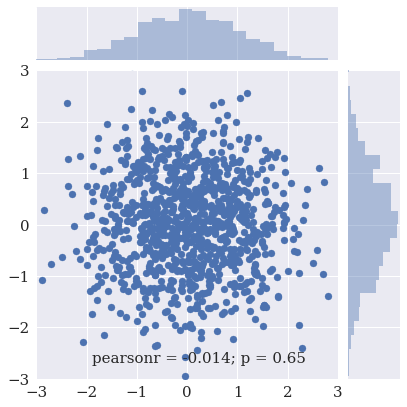

In [7]:
g = sns.jointplot(x, y, kind='scatter', xlim=(-3,3), ylim=(-3,3))

## Generating multivariate normal random deviates

In [16]:
def mvn(mu, sigma, n=1):
    """Generate n samples from multivarate normal with mean mu and covariance sigma."""
    p = len(mu)
    A = np.linalg.cholesky(sigma)
    z = np.random.randn(n, p)
    return mu + z @ A.T

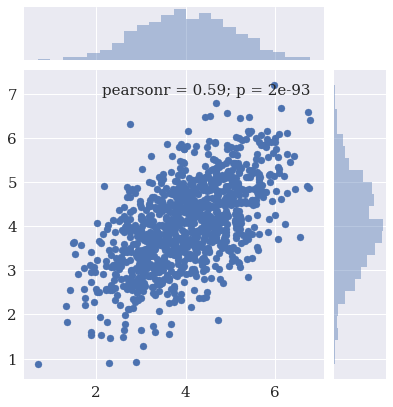

In [19]:
mu, sigma = 4.0*np.ones(2), np.array([[1,0.6], [0.6, 1]])
n = 1000
x, y = mvn(mu, sigma, n).T
g = sns.jointplot(x, y, kind='scatter')

## Rejection sampling

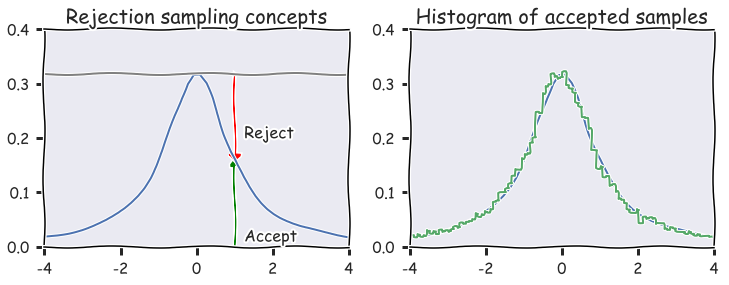

In [18]:
# Suppose we want to sample from the truncated Cauchy distribution 
# We use the uniform as a proposal distibution (highly inefficient)

x = np.linspace(-4, 4)

dist = stats.cauchy()
upper = dist.pdf(0)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, dist.pdf(x))
    plt.axhline(upper, color='grey')
    px = 1.0
    plt.arrow(px,0,0,dist.pdf(1.0)-0.01, linewidth=1,
              head_width=0.2, head_length=0.01, fc='g', ec='g')
    plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01), linewidth=1, 
              head_width=0.3, head_length=0.01, fc='r', ec='r')
    plt.text(px+.25, 0.2, 'Reject', fontsize=16)
    plt.text(px+.25, 0.01, 'Accept', fontsize=16)
    plt.axis([-4,4,0,0.4])
    plt.title('Rejection sampling concepts', fontsize=20)

    plt.subplot(122)
    n = 100000
    # generate from sampling distribution
    u = np.random.uniform(-4, 4, n)
    # accept-reject criterion for each point in sampling distribution
    r = np.random.uniform(0, upper, n)
    # accepted points will come from target (Cauchy) distribution
    v = u[r < dist.pdf(u)]

    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

### Mixture representations

Sometimes, the target distribution from which we need to generate random numbers can be expressed as a mixture of "simpler" distributions that we already know how to sample from

$$
f(x) = \int{g(x\,|\,y)p(y) dy}
$$

For example, if $y$ is drawn from the $\chi_\nu^2$ distribution, then $\mathcal{N}(0, \nu/y)$ is a sample from the Student's T distribution with $\nu$ degrees of freedom.

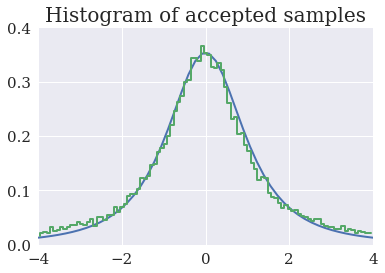

In [17]:
n = 10000
df = 2
dist = stats.t(df=df)
x = np.linspace(-4, 4)
y = stats.chi2(df=df).rvs(n)
r = stats.norm(0, df/y).rvs(n)

plt.plot(x, dist.pdf(x), linewidth=2)

# Plot scaled histogram 
factor = dist.cdf(4) - dist.cdf(-4)
hist, bin_edges = np.histogram(v, bins=100, normed=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.step(bin_centers, factor*hist, linewidth=2)

plt.axis([-4,4,0,0.4])
plt.title('Histogram of accepted samples', fontsize=20);

## Using the `numpy.random` and `scipy.stats` PRNGs

From this part onwards, we will assume that there is a library of PRNGs that we can use - either from `numpy.random` or scipy.stats which are both based on the Mersenne Twister, a high-quality PRNG for random integers. The `numpy` versions simply generate random deviates while the `scipy` versions will also provide useful functions related to the distribution, e.g. PDF, CDF and quantiles.

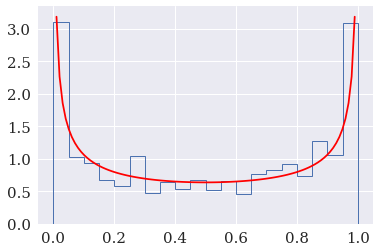

In [4]:
import numpy.random as rng

# Histogram of beta distribution
rs = rng.beta(a=0.5, b=0.5, size=1000)
plt.hist(rs, bins=20, histtype='step', normed=True, linewidth=1)

# PDF for the beta distribution
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta.pdf(xs, a=0.5, b=0.5), color='red')
pass